# Examples of Prior Model Knowledge and Poorly adjusted Samples 


Train Model

In [1]:
%%bash
if [ ! -d "/tmp/models" ]; then
  wget -nc -P /tmp https://syncandshare.lrz.de/dl/fi5Y1ZUyaY38NLXSzbbynDmA/models.tar.gz
  tar -xzf /tmp/models.tar.gz -C /tmp --keep-new-files
fi

In [1]:
import sys
sys.path.append('..')
from dataset import ModisDataset, Sentinel5Dataset
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from model import Model, snapshot, restore
import ignite.metrics
import pandas as pd
from train import train_epoch, test_epoch, test_model, fine_tune
from visualizations import make_and_plot_predictions, predict_future
from dataset import transform_data
from copy import deepcopy

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

num_layers = 1
hidden_size = 128
region = "germany"
epochs = 4
include_time = True # include time False works as well, but leads to models runing out of phase...

N_seen_points = 227
N_predictions = 100

def criterion(y_pred, y_data, log_variances):
    norm = (y_pred-y_data)**2
    loss = (torch.exp(-log_variances) * norm).mean()
    regularization = log_variances.mean()
    return 0.5 * (loss + regularization)

def setup(smooth, smooth_method="mean"):
    model = Model(input_size=1 if not include_time else 2,
                  hidden_size=hidden_size,
                  num_layers=num_layers,
                  output_size=1,
                  device=device)

    #model.load_state_dict(torch.load("/tmp/model_epoch_0.pth")["model"])
    model.train()

    enddate = None#'2010-01-01'

    dataset = ModisDataset(region=region,
                           fold="train",
                           znormalize=True,
                           augment=False,
                           overwrite=False,
                           include_time=include_time,
                           filter_date=(None,enddate),
                           smooth=smooth,
                           smooth_method=smooth_method)

    testdataset = ModisDataset(region=region,
                           fold="test",
                           znormalize=True,
                           augment=False,
                           overwrite=False,
                           include_time=include_time,
                           filter_date=(None,None),
                           smooth=smooth,
                           smooth_method=smooth_method)

    validdataset = ModisDataset(region=region,
                                fold="validate",
                                znormalize=True,
                                augment=False,
                                include_time=include_time,
                                smooth=smooth,
                                smooth_method=smooth_method)

    #dataset = Sentinel5Dataset(fold="train", seq_length=300)
    #validdataset = Sentinel5Dataset(fold="validate", seq_length=300)

    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=512,
                                             shuffle=True,
                                             #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                             )
    validdataloader = torch.utils.data.DataLoader(validdataset,
                                             batch_size=512,
                                             shuffle=False,
                                             #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                             )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

    return model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer

../train.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


File ‘/tmp/models.tar.gz’ already there; not retrieving.

tar: models/LSTM_germany_l=3_h=64_e=83.pth: Cannot open: File exists
tar: models/LSTM_volcanopuyehue_l=1_h=128_e=4.pth: Cannot open: File exists
tar: models/LSTM_volcanopuyehue_l=8_h=128_e=12.pth: Cannot open: File exists
tar: models/LSTM_volcanopuyehue_l=1_h=32_e=1_until2012-01-01.pth: Cannot open: File exists
tar: models/LSTM_germany_l=1_h=128_e=91.pth: Cannot open: File exists
tar: models/LSTM_volcanopuyehue_l=3_h=32_e=8.pth: Cannot open: File exists
tar: models/LSTM_germany_l=3_h=64_e=47.pth: Cannot open: File exists
tar: models/LSTM_volcanopuyehue_l=8_h=128_e=34.pth: Cannot open: File exists
tar: models/LSTM_germany_l=3_h=64_e=31.pth: Cannot open: File exists
tar: models/LSTM_volcanopuyehue_l=8_h=128_e=39.pth: Cannot open: File exists
tar: models/LSTM_germany_l=1_h=256_e=26.pth: Cannot open: File exists
tar: models/LSTM_germany_l=3_h=64_e=87.pth: Cannot open: File exists
tar: models/LSTM_germany_l=3_h=64_e=72.pth: Cannot op

CalledProcessError: Command 'b'wget -nc -P /tmp https://syncandshare.lrz.de/dl/fi5Y1ZUyaY38NLXSzbbynDmA/models.tar.gz\ntar -xzf /tmp/models.tar.gz -C /tmp --keep-old-files\n'' returned non-zero exit status 2.

local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz



epoch 0: train loss 0.18, test loss 0.16, mae=0.59, mse=0.56, rmse=0.75
saving model snapshot to /tmp/models/LSTM_germany_l=1_h=128_e=0.pth.pth



epoch 1: train loss 0.16, test loss 0.15, mae=0.58, mse=0.55, rmse=0.74
saving model snapshot to /tmp/models/LSTM_germany_l=1_h=128_e=1.pth.pth



epoch 2: train loss 0.15, test loss 0.14, mae=0.58, mse=0.54, rmse=0.74
saving model snapshot to /tmp/models/LSTM_germany_l=1_h=128_e=2.pth.pth



epoch 3: train loss 0.14, test loss 0.13, mae=0.57, mse=0.53, rmse=0.73
saving model snapshot to /tmp/models/LSTM_germany_l=1_h=128_e=3.pth.pth


Text(0, 0.5, 'loss')

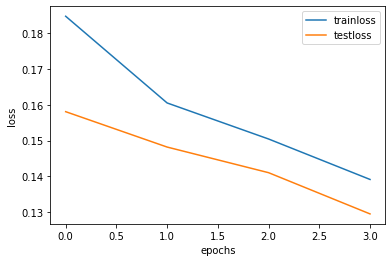

In [4]:
model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer = setup(None)

name_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_e={epoch}.pth"
model_dir = "/tmp/models"


stats=list()
for epoch in range(epochs):
    trainloss = train_epoch(model,dataloader,optimizer, criterion, device)
    testmetrics, testloss = test_epoch(model,validdataloader,device, criterion, n_predictions=1)
    metric_msg = ", ".join([f"{name}={metric.compute():.2f}" for name, metric in testmetrics.items()])
    msg = f"epoch {epoch}: train loss {trainloss:.2f}, test loss {testloss:.2f}, {metric_msg}"
    print(msg)

    #test_model(model, validdataset, device)

    model_name = name_pattern.format(region=region, num_layers=num_layers, hidden_size=hidden_size, epoch=epoch)
    pth = os.path.join(model_dir, model_name+".pth")
    print(f"saving model snapshot to {pth}")
    snapshot(model, optimizer, pth)
    stat = dict()
    stat["epoch"] = epoch
    for name, metric in testmetrics.items():
        stat[name]=metric.compute()

    stat["trainloss"] = trainloss.cpu().detach().numpy()
    stat["testloss"] = testloss.cpu().detach().numpy()
    stats.append(stat)

df = pd.DataFrame(stats)

fig,ax = plt.subplots()
ax.plot(df.epoch, df.trainloss, label="trainloss")
ax.plot(df.epoch, df.testloss, label="testloss")
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

## Visualization of the Prior Model

We only introduce a single time instance $t=0$ to see what representation the model learns in the absence of data


In [ ]:
N_seen_points = 1
idx = 10
make_and_plot_predictions(model, testdataset.data[idx].astype(float), date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

## Good Example
Likely represented well in the training dataset

In [ ]:
N_seen_points = 1
idx = 10

make_and_plot_predictions(model, testdataset.data[idx].astype(float), date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

## Here is one test example that is not well-represented in the training set

The model predicts systematically to low values

In [ ]:
N_seen_points = 1
idx = 17
make_and_plot_predictions(model, testdataset.data[idx].astype(float), date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

## Poor Example
Likely out-of-training-distribution. The model predicts systematilly to low values.

All model representations are affected equally. Hence, the epistemic model undertainty is underestimated 

In [ ]:
idx = 17

make_and_plot_predictions(model, testdataset.data[idx].astype(float), date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

### The poor example from above


In [ ]:
idx = 17
x = testdataset.data[idx].astype(float)

def predict_future(x, date, N_seen_points):
    future = x.shape[0] - N_seen_points
    x_ = torch.Tensor(x)[None, :].to(device)
    if x_.shape[2] == 2:
        doy_seen = x_[:, :N_seen_points, 1]
        doy_future = x_[:, N_seen_points:, 1]
    else:
        doy_seen = None
        doy_future=None
    x_data = x_[:, :N_seen_points, 0].unsqueeze(2)
    mean, epi_var, ale_var,y_hat = model.predict(x_data, 10, future, date=doy_seen, date_future=doy_future, return_yhat=True)
    var = epi_var + ale_var
    mean = mean.cpu().squeeze()
    var = var.cpu().squeeze()
    epi_var = epi_var.cpu().squeeze()
    ale_var = ale_var.cpu().squeeze()
    epi_std = torch.sqrt(epi_var[1:])
    ale_std = torch.sqrt(ale_var[1:])
    data_std = epi_std + ale_std
    return mean, data_std

fig,axs = plt.subplots(4,1,figsize=(14, 12))

ax = axs[0]
N_seen_points=250
mean_half_seen, data_std_half_seen = predict_future(x, date, N_seen_points)
ax.set_title("model mean and standard with one one seen data point")
ax.fill_between(date[1:], mean_half_seen[1:]-data_std_half_seen, mean_half_seen[1:]+data_std_half_seen)
ax.plot(date,mean_half_seen,'r')
ax.axvline(date[N_seen_points])

ax = axs[1]
N_seen_points=1
mean, data_std = predict_future(x, date, N_seen_points)
ax.set_title("model mean and standard with one one seen data point")
ax.fill_between(date[1:], mean[1:]-data_std, mean[1:]+data_std)
ax.plot(date,mean,'r')
ax.axvline(date[N_seen_points])

ax = axs[2]
ax.set_title("mean and standard from all training examples per time")
dataset_mean = dataset.data[:,:,0].mean(0)
dataset_std = dataset.data[:,:,0].std(0)

ax.fill_between(date, dataset_mean-dataset_std, dataset_mean+dataset_std)
ax.plot(date,dataset_mean,'r')

ax = axs[3]
ax.plot(date,mean_half_seen,'k', label="prior model mean with 250 seen points")
ax.plot(date,mean,'g', label="prior model mean with only one seen time point")
ax.plot(date,dataset_mean,'b', label="training dataset mean over all training examples")
ax.plot(date,x[:,0],'r', label="test sample")
ax.legend()